In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


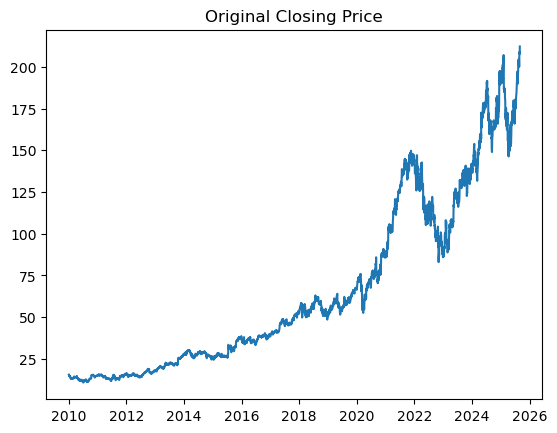

In [2]:
ticker = "GOOG"
df = yf.download(ticker, start="2010-01-01", end="2025-08-29")[["Close"]]
df.rename(columns={"Close":"close"}, inplace=True)
df.dropna(inplace=True)

plt.plot(df['close'])
plt.title("Original Closing Price")
plt.show()

In [3]:
result = adfuller(df["close"])
pvalue = result[1]
print("ADF p-value:", pvalue)
original_prices = df["close"].values  # original stock prices

ADF p-value: 0.9951337066030604


In [4]:
df["diff"] = df["close"].diff()
df.dropna(inplace=True)

stationary_series = df["diff"].values.reshape(-1,1)

In [5]:
result = adfuller(df["close"])
pvalue = result[1]
print("ADF p-value:", pvalue)
original_prices = df["close"].values  # original stock prices

ADF p-value: 0.9951198131062234


In [6]:
random_noise = df['close'].diff().dropna()

mean_noise = random_noise.mean()
mean_noise

Ticker
GOOG    0.049986
dtype: float64

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(stationary_series)

In [8]:
def create_dataset(data, time_step=50):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 50
X, y = create_dataset(scaled, time_step)

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_diff_pred_scaled = lr.predict(X_test)

In [11]:
lr_diff_pred = scaler.inverse_transform(lr_diff_pred_scaled.reshape(-1,1))
y_test_diff_inv = scaler.inverse_transform(y_test.reshape(-1,1))    

In [12]:
test_start = time_step + train_size

prev_prices = original_prices[test_start-1 : test_start-1 + len(lr_diff_pred)]
lr_price_pred = prev_prices + lr_diff_pred.flatten()
actual_price_test = original_prices[test_start : test_start + len(lr_diff_pred)]

prev_prices = prev_prices.reshape(-1)     
lr_diff_pred = lr_diff_pred.reshape(-1)  
actual_price_test = actual_price_test.reshape(-1)

In [13]:
lr_price_pred = prev_prices + lr_diff_pred

In [15]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
ridge_diff_pred_scaled = ridge.predict(X_test)
ridge_diff_pred = scaler.inverse_transform(ridge_diff_pred_scaled.reshape(-1,1))

ridge_price_pred = prev_prices + ridge_diff_pred.flatten()

In [16]:
X_train_lstm = X_train.reshape(X_train.shape[0], time_step, 1)
X_test_lstm  = X_test.reshape(X_test.shape[0], time_step, 1)

model = Sequential([
    LSTM(64, input_shape=(time_step,1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32,
          validation_data=(X_test_lstm, y_test), verbose=1)

lstm_diff_pred_scaled = model.predict(X_test_lstm)
lstm_diff_pred = scaler.inverse_transform(lstm_diff_pred_scaled)
lstm_price_pred = prev_prices + lstm_diff_pred.flatten()

Epoch 1/20


c:\Users\dpiso\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0176 - val_loss: 0.0091
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0091
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0092
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - val_loss: 0.0091
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0091
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0090
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0095
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021 - val_loss: 0.0090
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0090
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_l

In [17]:
ridge_diff_pred = ridge_diff_pred.reshape(-1)
ridge_price_pred = prev_prices + ridge_diff_pred

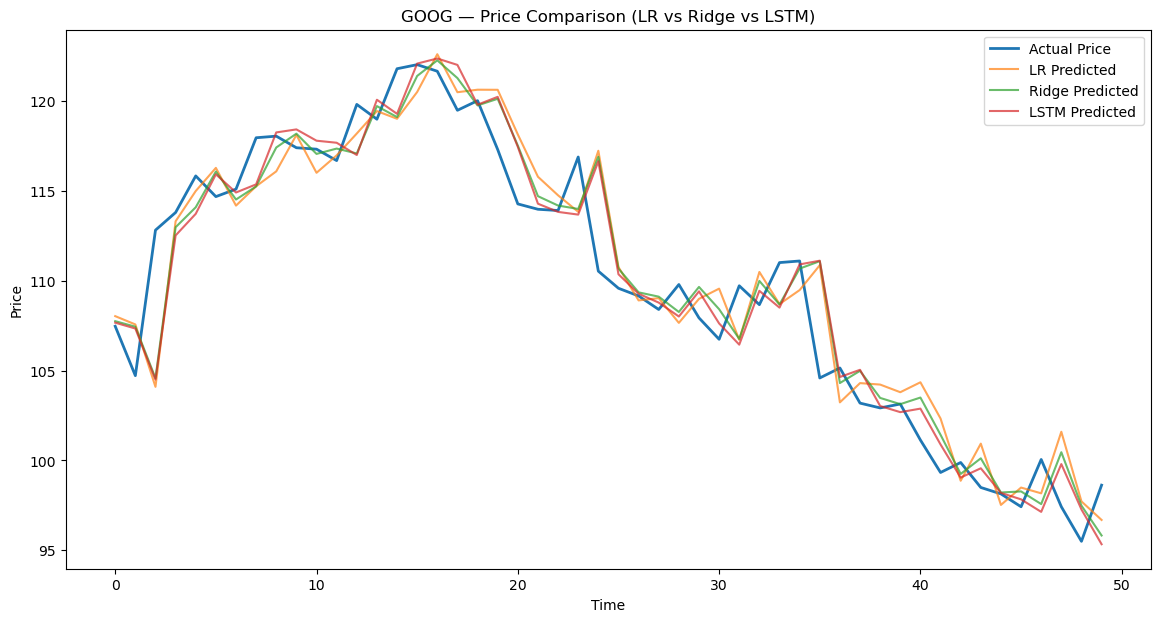

In [18]:
lstm_diff_pred = lstm_diff_pred.reshape(-1)
lstm_price_pred = prev_prices + lstm_diff_pred

plt.figure(figsize=(14,7))
plt.plot(actual_price_test[:50], label="Actual Price", linewidth=2)
plt.plot(lr_price_pred[:50], label="LR Predicted", alpha=0.7)
plt.plot(ridge_price_pred[:50], label="Ridge Predicted", alpha=0.7)
plt.plot(lstm_price_pred[:50], label="LSTM Predicted", alpha=0.7)

plt.title(f"{ticker} — Price Comparison (LR vs Ridge vs LSTM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()